In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

### Base Input

In [13]:
df = pd.read_csv('bananaindex.csv')
df = pd.get_dummies(df, drop_first=True)

print(df.head())

X = df[['land_use_kg', 'land_use_1000kcal', 'Land use per 100 grams of protein', 'Land use per 100 grams of fat']].values
y = df[['Bananas index (kg)', 'Bananas index (1000 kcalories)', 'Bananas index (100g protein)']].values

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Divide dataset
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

   year  emissions_kg  emissions_1000kcal  emissions_100g_protein  \
0  2022      0.488690            0.317338                0.878525   
1  2022      0.387011            0.067265                0.207599   
2  2022      0.655888            2.222230               13.595512   
3  2022      0.602368            0.105029                0.328335   
4  2022      0.458378            0.955184               29.152212   

   emissions_100g_fat  land_use_kg  land_use_1000kcal  \
0            2.424209     0.811485           0.601152   
1            0.079103     7.683045           1.296870   
2            4.057470     1.370106           2.675063   
3            0.119361     8.230927           1.423376   
4           19.754980     0.660629           1.382839   

   Land use per 100 grams of protein  Land use per 100 grams of fat  \
0                           1.577687                       3.065766   
1                           3.608433                       1.495297   
2                          12

In [28]:
def model_wrap(model_input):
    multi_output_model = MultiOutputRegressor(model_input)
    multi_output_model.fit(X_train, y_train)
    return multi_output_model.predict(X_test)

def evaluate(y_test, y_pred, model_name=None):
    # Evaluate the model
    for r in range(y_test.shape[1]):
        r2 = r2_score(y_test[:, r], y_pred[:, r])
        print(f'R-squared for the {r + 1} target: {r2}')

    plt.figure(figsize=(14, 4))

    for i in range(y_test.shape[1]):
        plt.subplot(1, y_test.shape[1], i+1)
        plt.scatter(y_test[:, i], y_pred[:, i], color='blue', label='Actual vs Predicted')
        plt.title(f'Target {i+1}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')

        min_val = min(y_test[:, i].min(), y_pred[:, i].min())
        max_val = max(y_test[:, i].max(), y_pred[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()

    # Set the overall title
    if model_name:
        plt.suptitle(f'Evaluation of {model_name}', fontsize=16, y=1.05)

    plt.show()

## Linear Regression

R-squared for the 1 target: 0.9562964971989435
R-squared for the 2 target: 0.8725734065893976
R-squared for the 3 target: 0.526116692992443


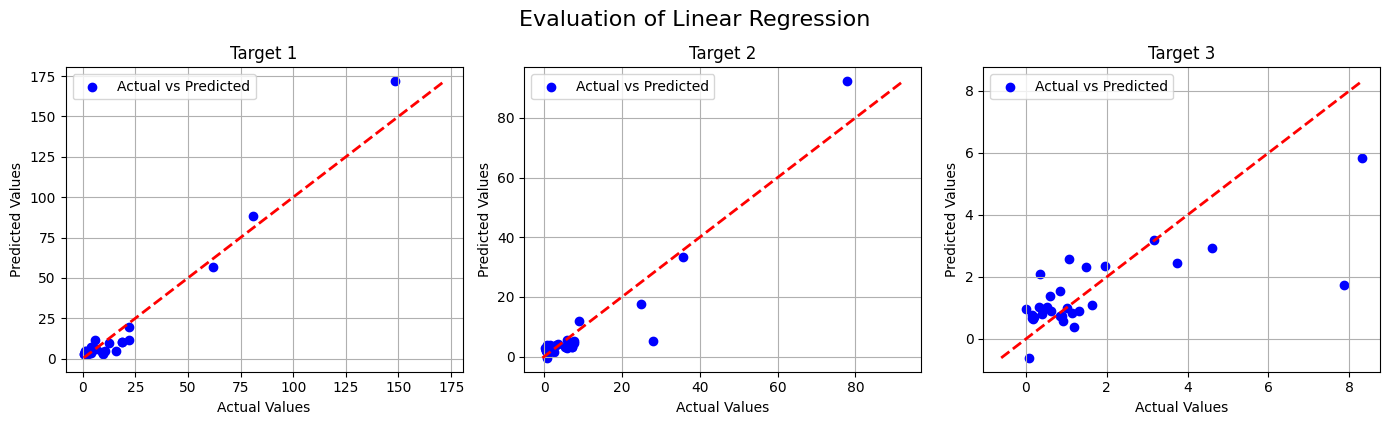

In [29]:
base_model = LinearRegression()
y_pred = model_wrap(base_model)
evaluate(y_test, y_pred, 'Linear Regression')

## Random Forest Regression Model

R-squared for the 1 target: 0.8060561430879649
R-squared for the 2 target: 0.7673060132953035
R-squared for the 3 target: 0.5975070778939564


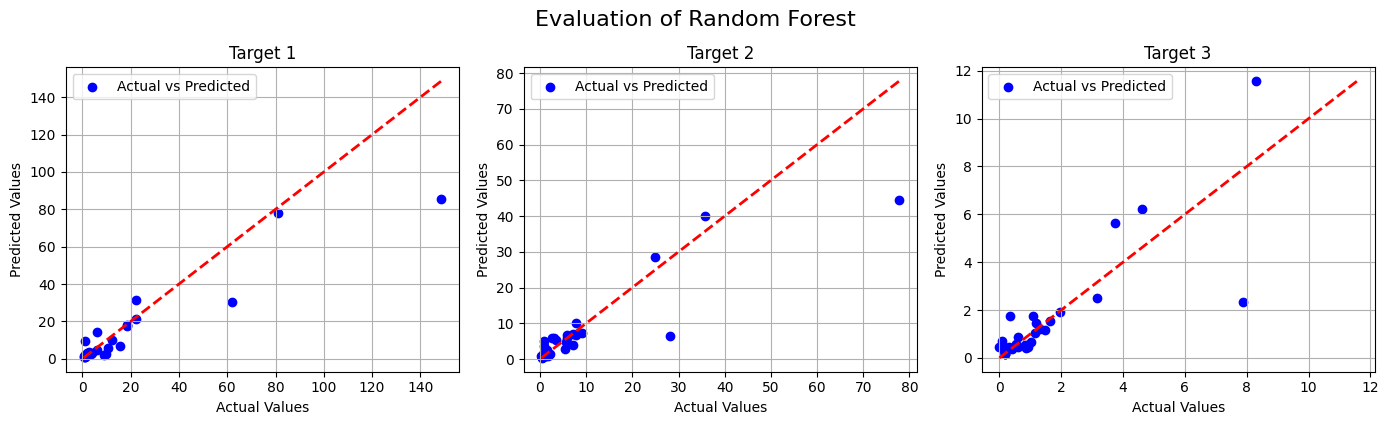

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
y_pred = model_wrap(rf_model)
evaluate(y_test, y_pred, 'Random Forest')

## Grid Search Model

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from grid search:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}
R-squared for the 1 target: 0.7780623149773402
R-squared for the 2 target: 0.6789446928776764
R-squared for the 3 target: 0.5856778379605532


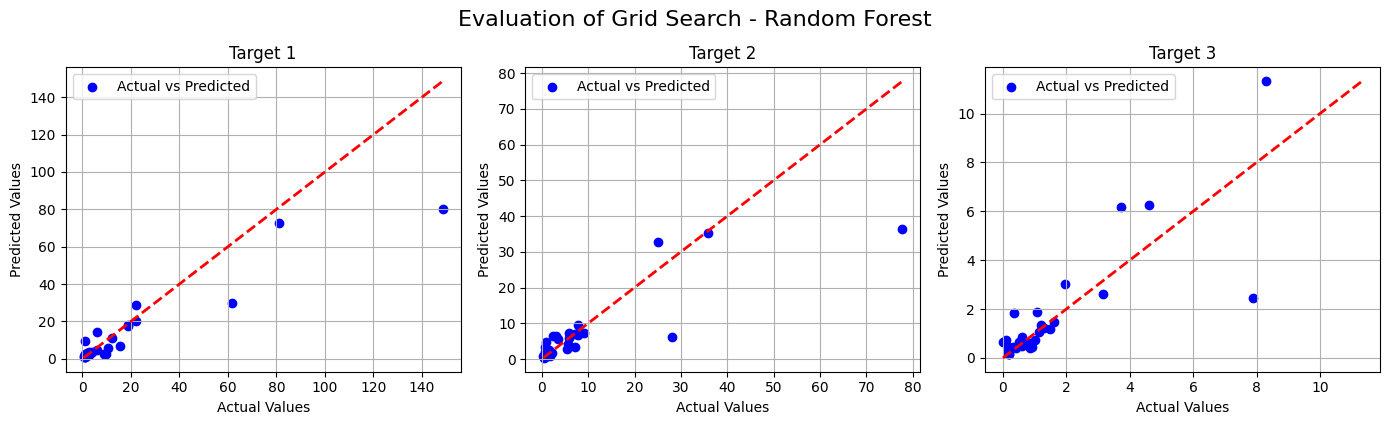

In [31]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForestRegressor
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

# Initialize the grid search model
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # Number of folds for cross-validation
    verbose=2,  # Controls the verbosity: the higher, the more messages
    n_jobs=-1,
)  # Number of jobs to run in parallel

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and associated model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best parameters from grid search: ", best_params)

y_pred = model_wrap(best_rf_model)
evaluate(y_test, y_pred, 'Grid Search - Random Forest')

## Pipe Line 

R-squared for the 1 target: 0.7780623149773402
R-squared for the 2 target: 0.6789446928776764
R-squared for the 3 target: 0.5856778379605532


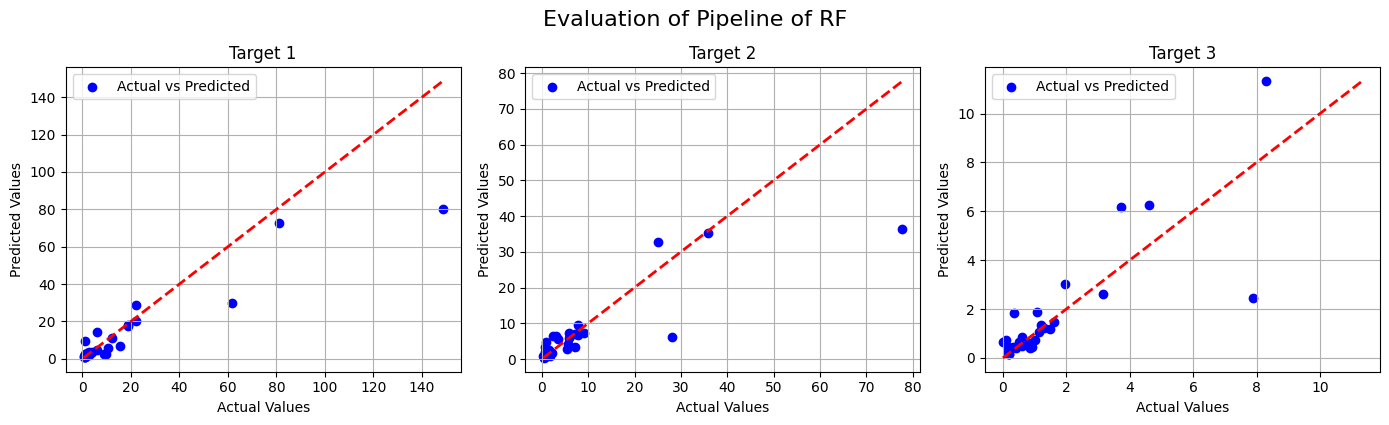

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# A pipeline with StandardScaler and the best RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(**best_params, random_state=42))  # Using best_params found from grid search
])

y_pred = model_wrap(pipeline)
evaluate(y_test, y_pred, 'Pipeline of RF')

### Neural Network

Epoch 1/50
4/4 [==============================] - 1s 41ms/step - loss: 82.2625 - val_loss: 105.8702
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 79.4698 - val_loss: 104.7290
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 79.9291 - val_loss: 103.5262
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 78.3100 - val_loss: 102.2566
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 80.7580 - val_loss: 101.0001
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 75.5827 - val_loss: 99.6748
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 72.6125 - val_loss: 98.1874
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 70.4798 - val_loss: 96.5642
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 70.1379 - val_loss: 94.7711
Epoch 10/50
4/4 [==============================] - 0s 8ms/step - loss: 67.2657 - val_loss: 92.7705
Epoch 11/50
4

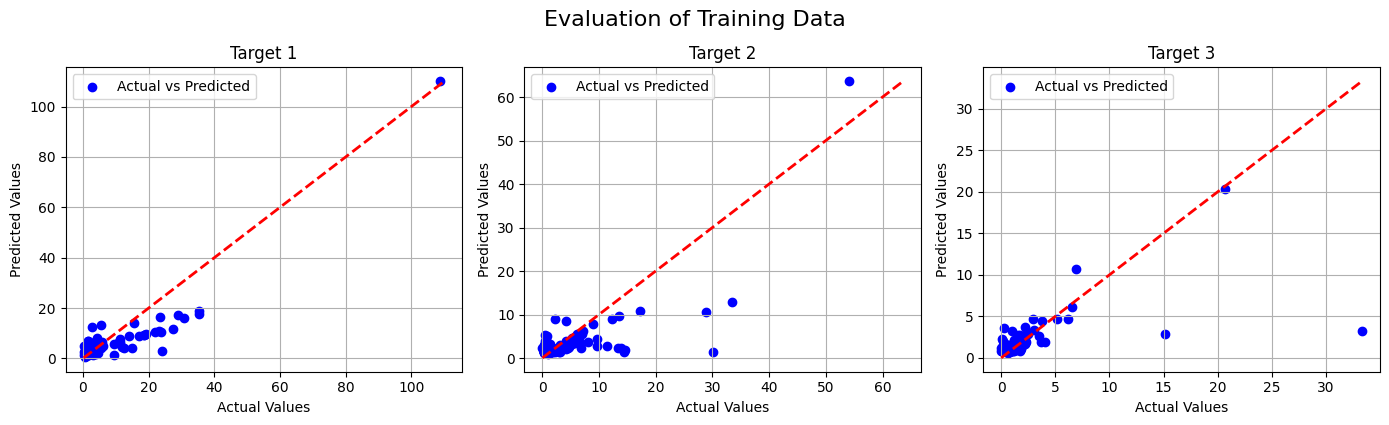

R-squared for the 1 target: 0.9663866246588191
R-squared for the 2 target: 0.8496729735260374
R-squared for the 3 target: 0.18946416695532253


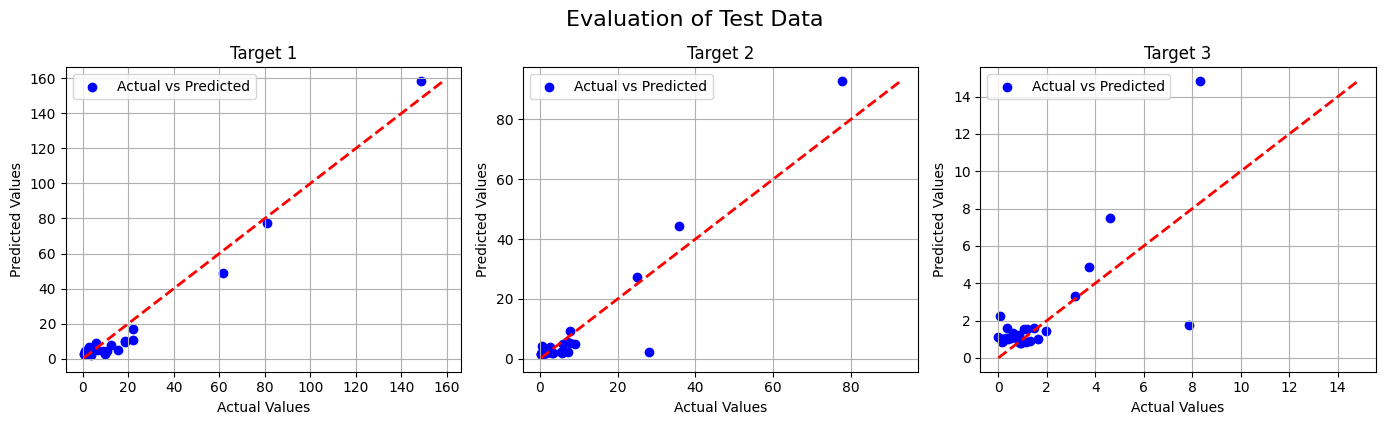

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Data preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Another Dropout layer
model.add(Dense(y_train.shape[1]))  # No activation for a regression problem

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with a validation split
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,  # More epochs with early stopping
    batch_size=32,
    validation_split=0.2,  # Use part of the training data for validation
    callbacks=[early_stopping]
)

# Predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Evaluate
evaluate(y_train, y_pred_train, 'Training Data')
evaluate(y_test, y_pred_test, 'Test Data')

### Bayesian Optimized NN

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

space = {
    'units1': hp.choice('units1', [64, 128, 256]),
    'dropout1': hp.uniform('dropout1', 0, 0.5),
    'units2': hp.choice('units2', [32, 64, 128]),
    'dropout2': hp.uniform('dropout2', 0, 0.5),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop'])
}

# Define the function to build the model
# Define the function to build the model
def build_model(units1, dropout1, units2, dropout2, optimizer):
    model = tf.keras.models.Sequential([
        Dense(units1, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(dropout1),
        Dense(units2, activation='relu'),
        Dropout(dropout2),
        Dense(y_train.shape[1])  # Output layer with no activation for regression
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define the objective function for hyperopt
def objective(hyperparams):
    # Extract batch_size and remove from hyperparams as it's not needed for build_model
    batch_size = hyperparams.pop('batch_size')
    model = build_model(**hyperparams)
    model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=100, verbose=0)
    
    # Add batch_size back to hyperparams for any further use
    hyperparams['batch_size'] = batch_size
    
    y_pred_test = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred_test)
    return {'loss': mse, 'status': STATUS_OK}

# Run the hyperparameter optimization
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Correctly extract the best hyperparameters, including batch_size
best_units1 = [64, 128, 256][best_hyperparams['units1']]
best_dropout1 = best_hyperparams['dropout1']
best_units2 = [32, 64, 128][best_hyperparams['units2']]
best_dropout2 = best_hyperparams['dropout2']
best_batch_size = [16, 32, 64][best_hyperparams['batch_size']]
best_optimizer = ['adam', 'rmsprop'][best_hyperparams['optimizer']]

# Re-train the model with the best hyperparameters
best_model = build_model(best_units1, best_dropout1, best_units2, best_dropout2, best_optimizer)
best_model.fit(X_train_scaled, y_train, batch_size=best_batch_size, epochs=100, verbose=0)

# Predict with the best model
y_pred_test = best_model.predict(X_test_scaled)

# Evaluate the best model
evaluate(y_test, y_pred_test, model_name="Best Model")


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: build_model() got an unexpected keyword argument 'batch_size'



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


TypeError: build_model() got an unexpected keyword argument 'batch_size'

## Feature Importance Visualization for RandomForestRegressor

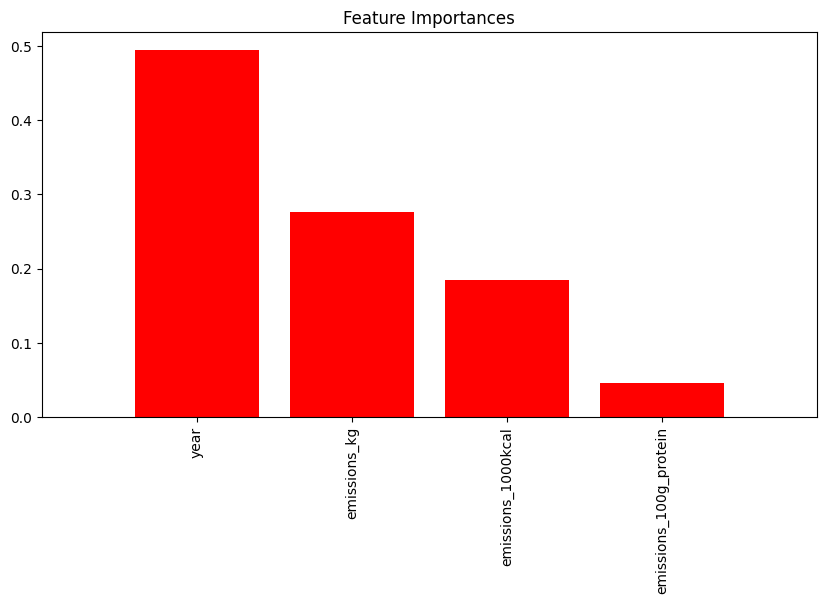

In [18]:
# Feature importance for RandomForestRegressor
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = df.columns[:len(importances)]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Visualizing GridSearchCV Results

In [19]:
import seaborn as sns

# Heatmap for GridSearchCV results
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(index='param_n_estimators',
                                  columns='param_max_depth',
                                  values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title("Grid Search R-squared Scores")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

## Residual Plot for LinearRegression

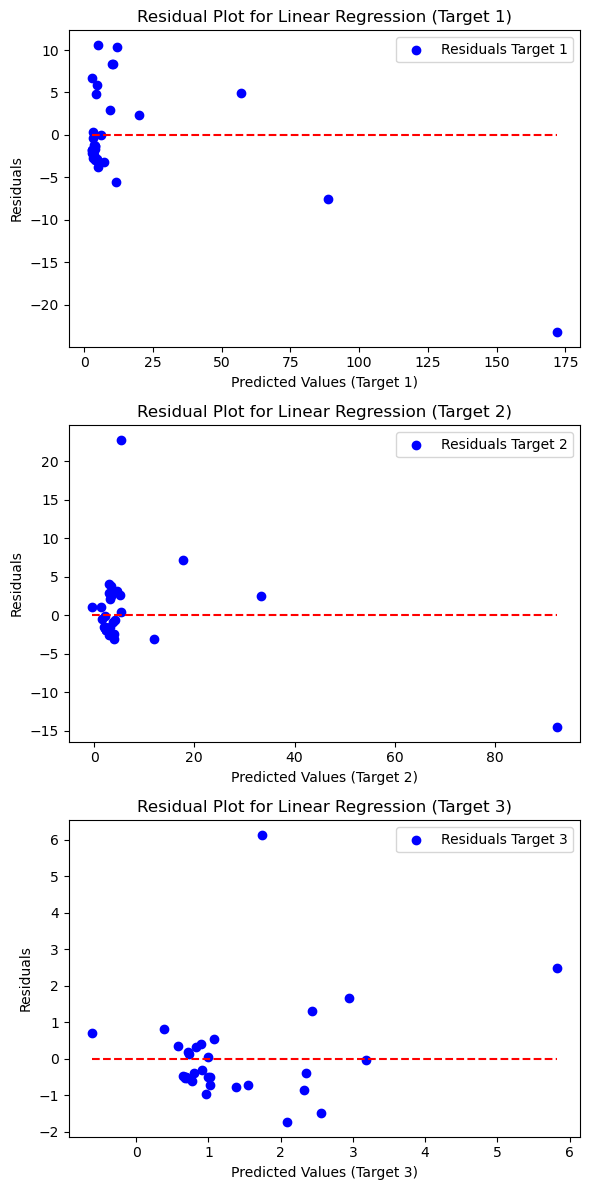

In [ ]:
# Number of targets
n_targets = y_test.shape[1]

# Create a figure with a subplot for each target
fig, axes = plt.subplots(n_targets, 1, figsize=(6, 4 * n_targets))

# Loop through each target for residual plots
for i in range(n_targets):
    residuals = y_test[:, i] - y_pred[:, i]
    axis = axes[i] if n_targets > 1 else axes
    axis.scatter(y_pred[:, i], residuals, color='blue', label=f'Residuals Target {i+1}')
    axis.hlines(0, np.min(y_pred[:, i]), np.max(y_pred[:, i]), colors='red', linestyles='--')
    axis.set_xlabel(f'Predicted Values (Target {i+1})')
    axis.set_ylabel('Residuals')
    axis.set_title(f'Residual Plot for Linear Regression (Target {i+1})')
    axis.legend()

plt.tight_layout()
plt.show()

## Actual vs Predicted values

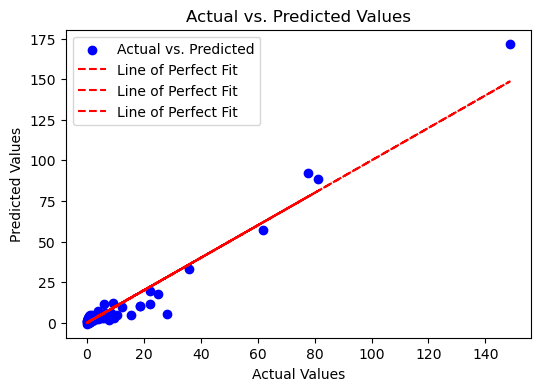

In [ ]:
# Actual vs Predicted scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot(y_test, y_test, color='red', label='Line of Perfect Fit', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

## Nutritional Footprint Index

In [ ]:
# Display dataframe columns to confirm 'entity' exists
# print("Columns in the dataframe:", df.columns)

# Extract the original 'entity' name from the one-hot encoded columns
# Taking maximum from entity columns, and then getting the column name
df['entity'] = df.filter(regex='^entity_').idxmax(axis=1)

# Remove the 'entity_' prefix from the entity column values
df['entity'] = df['entity'].str.replace('entity_', '')

# Proceed with the Nutritional Footprint Index (NFI) calculations

# A simplistic example formula could look like the following:
df['Env_Cost'] = (df['emissions_kg'] + df['land_use_kg']) / 2
df['Nutritional_Value'] = (df['emissions_1000kcal'] + df['emissions_100g_protein'] + df['emissions_100g_fat']) / 3

# Normalize the Environmental Cost and Nutritional Value
df['Normalized_Env_Cost'] = (df['Env_Cost'] - df['Env_Cost'].min()) / (df['Env_Cost'].max() - df['Env_Cost'].min())
df['Normalized_Nutri_Value'] = (df['Nutritional_Value'] - df['Nutritional_Value'].min()) / (df['Nutritional_Value'].max() - df['Nutritional_Value'].min())

# Assume lower environmental cost is better hence calculate inverse so that a larger NFI is better
df['NFI'] = df['Normalized_Nutri_Value'] / (df['Normalized_Env_Cost'] + 0.0001)  # Small number to avoid division by zero
    
# Sort the dataframe based on the index to find the most efficient foods
df_sorted = df.sort_values(by='NFI', ascending=False)

# Display the sorted dataframe with 'entity' and 'NFI'
print(df_sorted[['entity', 'NFI']].head(50))  # Show top 5 results

              entity         NFI
109           Onions  414.822469
148            Sugar  168.440645
4        Apple juice  165.729887
52      Coconut milk  131.371548
6             Apples  116.461309
110     Orange juice   93.798215
92             Limes   89.956403
89            Lemons   88.877083
111          Oranges   88.419077
154         Tomatoes   79.611802
118            Pears   73.754729
39   Cherry tomatoes   69.444597
95         Marmalade   68.307804
122        Pineapple   62.207183
107         Oat milk   57.824733
80            Grapes   50.917561
99             Melon   49.999833
153   Tomato ketchup   49.617278
158       Watermelon   44.281558
29           Cabbage   43.801797
136      Raspberries   41.167163
129         Potatoes   39.171737
64          Cucumber   38.421500
35       Cauliflower   38.049165
53       Coconut oil   34.594921
85             Kiwis   34.411288
27          Broccoli   29.809527
84              Kale   27.948190
33           Carrots   27.692691
121       

   - A higher NFI value indicates that the food item provides more nutrition per environmental cost unit. In other words, it's a more 'eco-efficient' or 'sustainable' choice from the viewpoint of emissions and land use for the nutritional content it provides.
   - The NFI is attempting to encapsulate the trade-off between the environmental impact of producing the food and the nutritional benefits it offers. 